In [242]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from web3 import Web3, WebsocketProvider
from functools import reduce
import operator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [243]:
# VARS
etherscan = "https://api.etherscan.io/api"
etherscan_api_key = "5XWEM6Q2DX2JPWIGXQA1C1PBAIQXIXHNNG"
web3_provider_uri = "wss://mainnet.infura.io/ws/v3/8eb1e2be2fbf4398bd64d2ce31d48d55"
blocks_out_api = "https://blockscout.com/eth/mainnet/api"
# latest carbonevote block is 4288305
voting_by_block = 4288305 #"latest" 

In [308]:
labels = ["no", "yes_0≤reward<1.5", "yes_1.5≤reward<2", "yes_2≤reward<3", "yes_3≤reward<4", "yes_reward≥4"]

In [330]:
only_basik_exchanges = False
addresses_to_filter = [
    {"key": "Yunbi", "value": "0xd94c9ff168dc6aebf9b6cc86deff54f3fb0afc33"},
    {"key": "Kraken", "value": "0x2910543af39aba0cd09dbb2d50200b3e800a63d2"},
    {"key": "Poloniex", "value": "0x32be343b94f860124dc4fee278fdcbd38c102d88"},
    {"key": "Bitfinex", "value": "0xcafb10ee663f465f9d10588ac44ed20ed608c11e"},
    {"key": "BTC-e", "value": "0x91337a300e0361bddb2e377dd4e88ccb7796663d"},
    {"key": "BitcoinToYou", "value": "0xf4fe90e63f2a90710bcc0c00f38812c4a882f2ff"},
    {"key": "Shapeshift1", "value": "0x120a270bbc009644e35f0bb6ab13f95b8199c4ad"},
    {"key": "Shapeshift2", "value": "0x9e6316f44baeeee5d41a1070516cc5fa47baf227"},
    {"key": "f2pool", "value": "0x61c808d82a3ac53231750dadc13c777b59310bd9"},
    {"key": "DwarfPool1", "value": "0x2a65aca4d5fc5b5c859090a6c34d164135398226"},
    {"key": "Gemini", "value": "0xd24400ae8bfebb18ca49be86258a3c749cf46853"},
    {"key": "Binance", "value": "0x3f5CE5FBFe3E9af3971dD833D26bA9b5C936f0bE"}
]


In [245]:
# web3 Instance
w3 = Web3(WebsocketProvider(web3_provider_uri, websocket_timeout=40))

In [246]:
# Read all data
ct_no = pd.read_csv("./data/no.csv", sep=",", index_col=False)
ct_0 = pd.read_csv("./data/yes_0≤reward<1.5.csv", sep=",", index_col=False)
ct_1 = pd.read_csv("./data/yes_1.5≤reward<2.csv", sep=",", index_col=False)
ct_2 = pd.read_csv("./data/yes_2≤reward<3.csv", sep=",", index_col=False)
ct_3 = pd.read_csv("./data/yes_3≤reward<4.csv", sep=",", index_col=False)
ct_4 = pd.read_csv("./data/yes_reward≥4.csv", sep=",", index_col=False)
dataFrames = [ct_no, ct_0, ct_1, ct_2, ct_3, ct_4]

In [247]:
# Remove all unsuccessful transactions
error_colum = 'Status'
dataFrames = list(map(lambda df: df[pd.isnull(df[error_colum])], dataFrames))

In [248]:
# Drop unused colums
drop_colums = ["ContractAddress", "Value_OUT(ETH)", "Status", "ErrCode"]
dataFrames = list(map(lambda df: df.drop(columns=drop_colums), dataFrames))

In [249]:
# Convert Raw Data
for frame in dataFrames:
    frame["DateTimeObj"] = pd.to_datetime(frame.DateTime)

In [251]:
# load count mined blocks per address

def load_mined_blocks(address):
    payload = {
        'module': 'account',
        'action': 'getminedblocks',
        'address': address,
        'blocktype': 'blocks',
        'apikey': etherscan_api_key
    }
    headers = {'Content-Type': 'application/json'}
    response_raw = requests.get(etherscan, params=payload, headers=headers)
    
    response_raw = response_raw.json()

    if response_raw.get('status') == '1':
        return response_raw.get('result')

    if response_raw.get('status') == '0':
        return []
    return []

dfs = dataFrames

for frame in dfs:
    addresses = frame.From
    mined_blocks = []
    for address in addresses:
        blocks_count = len(load_mined_blocks(address))
        mined_blocks.append(blocks_count)
        
    frame["BlocksMined"] = blocks_count


In [ ]:
# how many miners voted
miners_existance_by_table = []
for frame in dfs:
    blocks_col = frame.BlocksMined    
    is_present_miners = max(blocks_col) > 0
    miners_existance_by_table.append(is_present_miners)
    
miners_existance_by_table

In [252]:
# Load balances for each address on time of the block: voting_by_block

for frame in dfs:
    addresses = frame.From
    balances = []
    balances_wei = []
    for address in addresses:
        wei = w3.eth.getBalance(Web3.toChecksumAddress(address), block_identifier=voting_by_block)
        eth = w3.fromWei(wei, 'ether')
        balances.append(float(eth))
        balances_wei.append(int(wei))

    frame["BalanceEth"] = balances
    frame["BalanceWei"] = balances_wei

In [253]:
# Load gas used for each address on time of the block: voting_by_block

def load_transactions(address, start_block, endblock=voting_by_block):
    payload = {
        'module': 'account',
        'action': 'txlist',
        'address': address,
        'startblock': start_block,
        'endblock': endblock,
    }
    headers = {'Content-Type': 'application/json'}
    r = requests.get(blocks_out_api, params=payload, headers=headers)
    response_raw = r.json()
    
    if response_raw.get('status') == '1':
        return response_raw.get('result')

    if response_raw.get('status') == '0':
        return []

for frame in dfs:
    addresses = frame.From
    gas_used_by_addresses = []
    transactions_count_by_addresses = []
    
    for address in addresses:
        gas_used = 0
        transactions_count = 0
        from_block_num = 0

        while True:
            try:
                transactions = load_transactions(address, start_block=from_block_num)

                if len(transactions) == 0:
                    break

                # get last transaction
                last_tx = transactions[-1]
                from_block_num = int(last_tx.get('blockNumber')) + 1

                transactions_gas = list(map(lambda tx: int(tx.get('gasUsed')), transactions))            
                transactions_gas = reduce(operator.add, transactions_gas)
                gas_used += transactions_gas
                transactions_count += len(transactions)

            except Exception as ex:
                "Error in load_transactions: {}. voter.address: {}, from_block: {}".format(ex, address, from_block_num)
                break
                
        gas_used_by_addresses.append(gas_used)
        transactions_count_by_addresses.append(transactions_count)
        
    frame["GasUsed"] = gas_used_by_addresses
    frame["TransactionsCount"] = transactions_count_by_addresses


In [265]:
dfs_original = dfs.copy()

In [331]:
def filter_only(addresses, dfs=dfs_original):
    return list(map(lambda df: df[df.From.isin(addresses)].reset_index(drop=True), dfs))

def filter_exept(addresses, dfs=dfs_original):
    return list(map(lambda df: df[~df.From.isin(addresses)].reset_index(drop=True), dfs))

raw_addresses = list(map(lambda a: a.get("value"), addresses_to_filter))

dfs_only_addresses = filter_only(addresses=only_addresses)
dfs_exept_addresses = filter_exept(addresses=only_addresses)

def title_for_address(address):
    for exchange in addresses_to_filter:
        if exchange.get("value") == address:
            return exchange.get("key")
    return "unknown"

filtered_by_addresses = list(map(lambda df: df.From, dfs_only_addresses))
votes_by_exchanges = []

for i in range(0, len(filtered_by_addresses)):
    addresses = filtered_by_addresses[i]
    for a in addresses:
        votes_by_exchanges.append("Title: {}, voted for: {}".format(title_for_address(a), labels[i]))

for vote in votes_by_exchanges:
    print("{}".format(vote))

Title: Gemini, voted for: yes_1.5≤reward<2
Title: BTC-e, voted for: yes_2≤reward<3
Title: Poloniex, voted for: yes_reward≥4


In [283]:
# dfs = dfs_original.copy()
dfs = dfs_exept_addresses.copy()

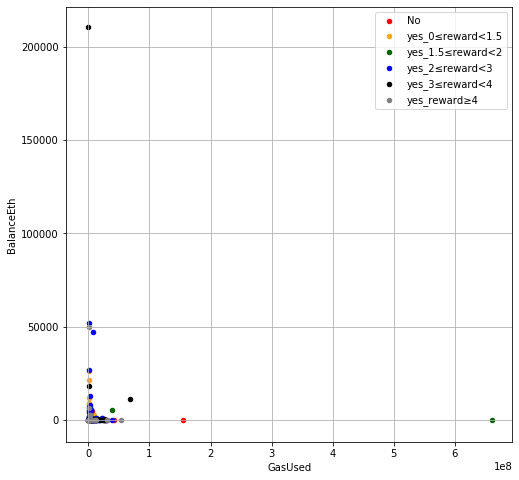

In [284]:
ax0 = dfs[0].plot.scatter(x='GasUsed', y='BalanceEth', color='Red', label='No', figsize=(8, 8));
ax1 = dfs[1].plot.scatter(x='GasUsed', y='BalanceEth', color='Orange', label='yes_0≤reward<1.5', ax=ax0);
ax2 = dfs[2].plot.scatter(x='GasUsed', y='BalanceEth', color='DarkGreen', label='yes_1.5≤reward<2', ax=ax1);
ax3 = dfs[3].plot.scatter(x='GasUsed', y='BalanceEth', color='Blue', label='yes_2≤reward<3', ax=ax2);
ax4 = dfs[4].plot.scatter(x='GasUsed', y='BalanceEth', color='Black', label='yes_3≤reward<4', ax=ax3);
ax5 = dfs[5].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Grey', label='yes_reward≥4', ax=ax4);

In [285]:
xmin = 0;
xmax = 0;

ymin = 0;
ymax = 0;


for frame in dfs:
    xmax = frame.GasUsed.max()
    ymax = frame.BalanceEth.max()
    
delta_koef = 0.05
delta_x = xmax * delta_koef
delta_y = ymax * delta_koef

xmin = 0 - delta_x
ymin = 0 - delta_y
xmax = xmax + delta_x
ymax = ymax + delta_y

print("GAS Max: {}".format(xmax))
print("ETH Max: {}".format(ymax))

GAS Max: 56558038.95
ETH Max: 52499.999069826


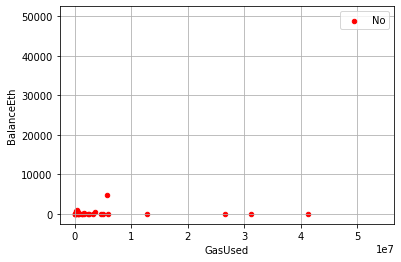

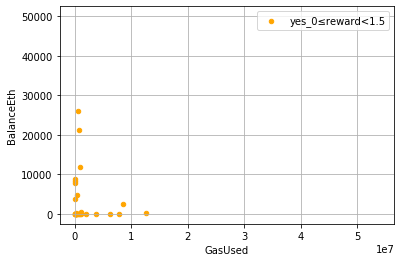

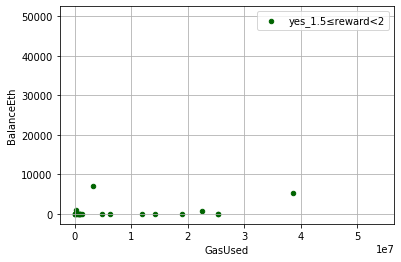

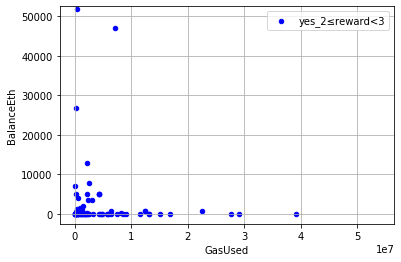

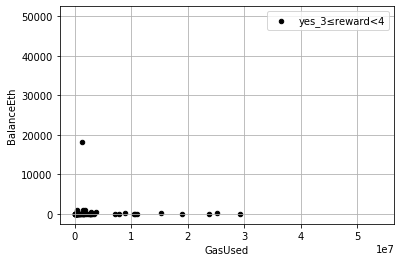

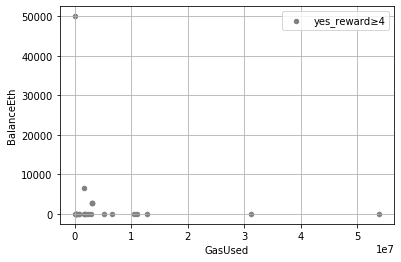

In [286]:
ax0 = dfs[0].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Red', label='No', xlim=[xmin, xmax], ylim=[ymin, ymax]);
ax1 = dfs[1].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Orange', label='yes_0≤reward<1.5', xlim=[xmin, xmax], ylim=[ymin, ymax]);
ax2 = dfs[2].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='DarkGreen', label='yes_1.5≤reward<2', xlim=[xmin, xmax], ylim=[ymin, ymax]);
ax3 = dfs[3].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Blue', label='yes_2≤reward<3', xlim=[xmin, xmax], ylim=[ymin, ymax]);
ax4 = dfs[4].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Black', label='yes_3≤reward<4', xlim=[xmin, xmax], ylim=[ymin, ymax]);
ax5 = dfs[5].plot.scatter(x='GasUsed', y='BalanceEth', grid=True, color='Grey', label='yes_reward≥4', xlim=[xmin, xmax], ylim=[ymin, ymax]);

In [287]:
# Calculate Comulative
for frame in dfs:
    frame["BalanceEthCumSum"] = frame.BalanceEth.cumsum()
    frame["GasUsedCumSum"] = frame.GasUsed.cumsum()

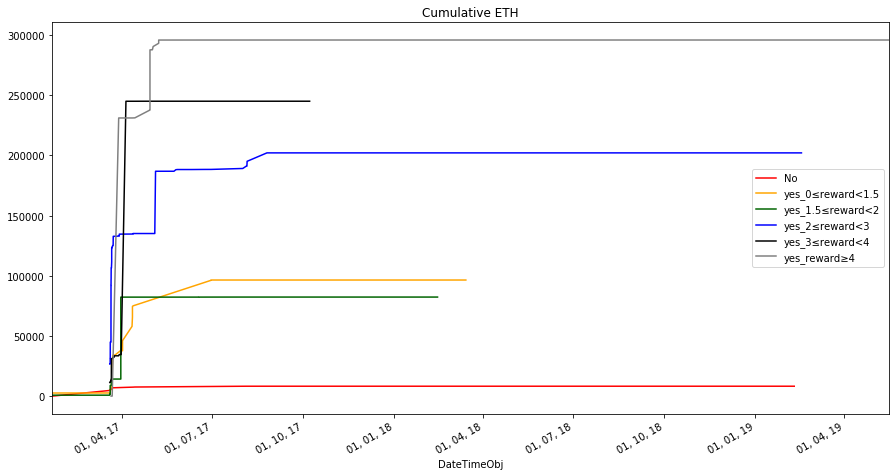

In [279]:
# Cumulative by ETH
ax0 = dfs[0].plot(x='DateTimeObj', y='BalanceEthCumSum', color='Red', label='No', figsize=(15, 8));
ax1 = dfs[1].plot(x='DateTimeObj', y='BalanceEthCumSum', color='Orange', label='yes_0≤reward<1.5', ax=ax0);
ax2 = dfs[2].plot(x='DateTimeObj', y='BalanceEthCumSum', color='DarkGreen', label='yes_1.5≤reward<2', ax=ax1);
ax3 = dfs[3].plot(x='DateTimeObj', y='BalanceEthCumSum', color='Blue', label='yes_2≤reward<3', ax=ax2);
ax4 = dfs[4].plot(x='DateTimeObj', y='BalanceEthCumSum', color='Black', label='yes_3≤reward<4', ax=ax3);
ax5 = dfs[5].plot(x='DateTimeObj', y='BalanceEthCumSum', color='Grey', label='yes_reward≥4', ax=ax4, title="Cumulative ETH");

myFmt = mdates.DateFormatter('%d, %m, %y')
ax4.xaxis.set_major_formatter(myFmt)

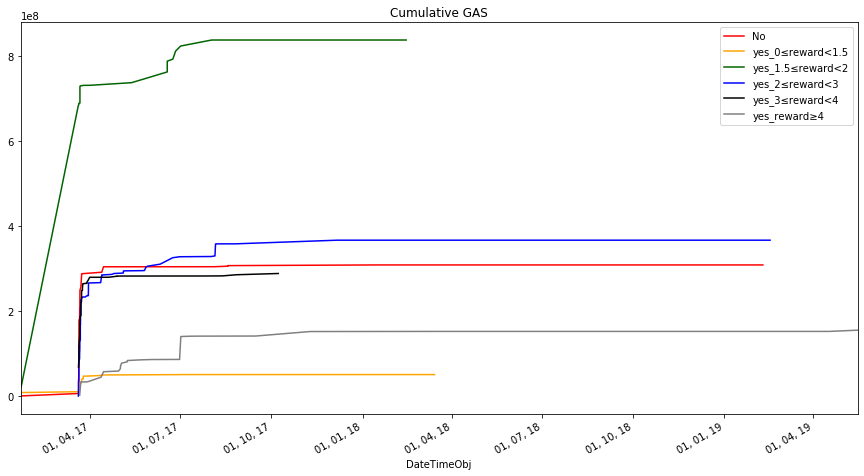

In [280]:
# Cumulative by GAS
ax0 = dfs[0].plot(x='DateTimeObj', y='GasUsedCumSum', color='Red', label='No', figsize=(15, 8));
ax1 = dfs[1].plot(x='DateTimeObj', y='GasUsedCumSum', color='Orange', label='yes_0≤reward<1.5', ax=ax0);
ax2 = dfs[2].plot(x='DateTimeObj', y='GasUsedCumSum', color='DarkGreen', label='yes_1.5≤reward<2', ax=ax1);
ax3 = dfs[3].plot(x='DateTimeObj', y='GasUsedCumSum', color='Blue', label='yes_2≤reward<3', ax=ax2);
ax4 = dfs[4].plot(x='DateTimeObj', y='GasUsedCumSum', color='Black', label='yes_3≤reward<4', ax=ax3);
ax5 = dfs[5].plot(x='DateTimeObj', y='GasUsedCumSum', color='Grey', label='yes_reward≥4', ax=ax4, title="Cumulative GAS");

myFmt = mdates.DateFormatter('%d, %m, %y')
ax0.xaxis.set_major_formatter(myFmt)

In [281]:
column_eth = "BalanceEth"
column_gas = "GasUsed"

combined_df = pd.concat(dfs, ignore_index=True, sort=False)

df_eth = combined_df.sort_values(by=column_eth, ascending=True).reset_index(drop=True)
balances_eth = df_eth.BalanceEth

count_voters = len(balances_eth)
index_1 = int(count_voters / 3)
index_2 = int(2 * (count_voters / 3))

eth_1_max = balances_eth[index_1]
eth_2_max = balances_eth[index_2]
eth_3_max = balances_eth[count_voters-1]


# Gas Used 
df_gas = combined_df.sort_values(by=column_gas, ascending=True).reset_index(drop=True)
consumes_gas = df_gas.GasUsed

gas_1_max = consumes_gas[index_1]
gas_2_max = consumes_gas[index_2]
gas_3_max = consumes_gas[count_voters-1]

print("ETH: ")
print("range 1: {}, {}".format(0, eth_1_max))
print("range 2: {}, {}".format(eth_1_max, eth_2_max))
print("range 3: {}, {}".format(eth_2_max, eth_3_max))
print("\n")
print("GAS: ")
print("range 1: {}, {}".format(0, gas_1_max))
print("range 2: {}, {}".format(gas_1_max, gas_2_max))
print("range 3: {}, {}".format(gas_2_max, gas_3_max))

ETH: 
range 1: 0, 0.013586455
range 2: 0.013586455, 67.991695969
range 3: 67.991695969, 231158.82307451265


GAS: 
range 1: 0, 463244
range 2: 463244, 2864732
range 3: 2864732, 660624081


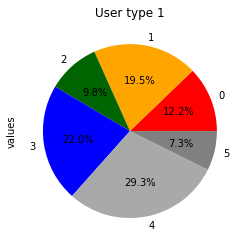

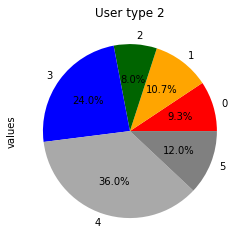

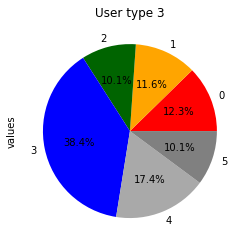

In [282]:
# Grouped by Value
# 254

def filtered_df(min_eth, max_eth, min_gas, max_gas):
    res = []
    for df in dfs:
        filtered = df[
            (df[column_eth] >= min_eth) & (df[column_eth] < max_eth) 
             &
            (df[column_gas] >= min_gas) & (df[column_gas] < max_gas)
        ]
        res.append(filtered.From.count())    
    return res

# Filtered by ranges
values_first_type = filtered_df(0, eth_1_max, 0, gas_1_max)

values_second_type = filtered_df(eth_1_max, eth_2_max, gas_1_max, gas_2_max)
values_second_type_2 = filtered_df(0, eth_1_max, gas_1_max, gas_2_max)
values_second_type_3 = filtered_df(eth_1_max, eth_2_max, 0, gas_1_max)

values_third_type = filtered_df(eth_2_max, (eth_3_max + 1), gas_2_max, (gas_3_max+1))
values_third_type_2 = filtered_df(0, eth_2_max, gas_2_max, (gas_3_max+1))
values_third_type_3 = filtered_df(eth_2_max, (eth_3_max + 1), 0, gas_2_max)

for i in range(0, len(dfs)):
    values_second_type[i] += values_second_type_2[i] + values_second_type_3[i]
    values_third_type[i] += values_third_type_2[i] + values_third_type_3[i]

# check weather right count
# alll = values_first_type + values_second_type + values_third_type
# print("{}".format(functools.reduce(lambda x, a: a+x, alll)))


colors = ["Red", "Orange", "DarkGreen", "Blue", "DarkGrey", "Grey"]

# Users typed
df_first_type = pd.DataFrame({"labels": labels, "values": values_first_type})
df_second_type = pd.DataFrame({"labels": labels, "values": values_second_type})
df_third_type = pd.DataFrame({"labels": labels, "values": values_third_type})

df_first_type.plot.pie(y = 'values', legend = False, autopct='%1.1f%%', colors=colors, title="User type 1");
df_second_type.plot.pie(y = 'values', legend = False, autopct='%1.1f%%', colors=colors, title="User type 2");
df_third_type.plot.pie(y = 'values', legend = False, autopct='%1.1f%%', colors=colors, title="User type 3");